In [50]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

%matplotlib inline

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer

In [59]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NaN,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NaN,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [5]:
df.converted.value_counts(normalize=True)

converted
1    0.619015
0    0.380985
Name: proportion, dtype: float64

In [61]:
pd.DataFrame({
    "missing_values": df.isnull().sum(),
    "dtypes": df.dtypes
})

,missing_values,dtypes
lead_source,128,object
industry,134,object
number_of_courses_viewed,0,int64
annual_income,181,float64
employment_status,100,object
location,63,object
interaction_count,0,int64
lead_score,0,float64
converted,0,int64


In [62]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0)

df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [63]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
print(len(df_train), len(df_val), len(df_test))

876 293 293


In [64]:
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 1

In [65]:
scores = []
for col in numerical:
    if roc_auc_score(y_train, df_train[col]) < 0.5:
        scores.append((col, roc_auc_score(y_train, -df_train[col])))
    scores.append((col, roc_auc_score(y_train, df_train[col])))
print(scores)

[('number_of_courses_viewed', 0.7635680590007088), ('annual_income', 0.5519578313253012), ('interaction_count', 0.738270176293409), ('lead_score', 0.6144993577250176)]


In [66]:
max(scores, key=lambda x: x[1])

('number_of_courses_viewed', 0.7635680590007088)

### Question 2

In [67]:
dv = DV(sparse=False)

train_dicts = df_train[categorical+numerical].to_dict(orient='records')
val_dicts = df_val[categorical+numerical].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [80]:
model = LR(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [81]:
y_pred = model.predict_proba(X_val)[:,1]
round(roc_auc_score(y_val, y_pred), 3)

0.817

### Question 3

/tmp/ipykernel_2065/1534485579.py:6: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


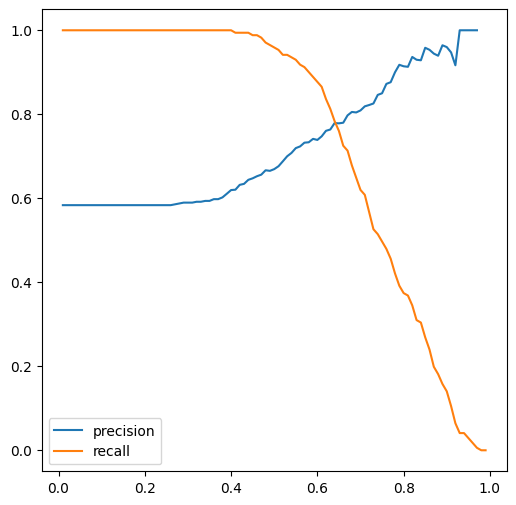

In [86]:
def precision_recall(y_true, y_pred, threshold):
    tp = ((y_true == 1) & (y_pred >= threshold)).sum()
    fp = ((y_true == 0) & (y_pred >= threshold)).sum()
    tn = ((y_true == 0) & (y_pred < threshold)).sum()
    fn = ((y_true == 1) & (y_pred < threshold)).sum()
    precision = tp / (tp + fp) 
    recall = tp / (tp + fn) 
    return precision, recall

thresholds = np.linspace(0.01, 0.99, 99)

precisions = []
recalls = []

for t in thresholds:
    precision, recall = precision_recall(y_val, y_pred, t)
    precisions.append(precision)
    recalls.append(recall)

plt.figure(figsize = (6,6))
plt.plot(thresholds, precisions, label = 'precision')
plt.plot(thresholds, recalls, label = 'recall')
plt.legend()

In [87]:
abs_diff = [abs(p-r) for p, r in zip(precisions, recalls)]
min_diff = min(abs_diff)
thresholds[abs_diff.index(min_diff)]

np.float64(0.64)

### Question 4

In [89]:
f1_scores = [2*(p*r)/(p+r) for p, r in zip(precisions, recalls)]
f1_scores[:5]

[np.float64(0.7370689655172414),
 np.float64(0.7370689655172414),
 np.float64(0.7370689655172414),
 np.float64(0.7370689655172414),
 np.float64(0.7370689655172414)]

In [90]:
max_f1 = max(f1_scores)
thresholds[f1_scores.index(max_f1)]

np.float64(0.5700000000000001)

### Question 5

In [91]:
def train(df, y_train, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LR(C=C, max_iter=1000, solver='liblinear')
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, movel):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [92]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [93]:
auc_scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    dv, model = train(df_train, df_train.converted.values)

    y_pred = predict(df_val, dv, model)

    auc_scores.append(roc_auc_score(df_val.converted.values, y_pred))

auc_scores
    

[0.8060745924216483,
 0.8713738368910783,
 0.7754320118852139,
 0.8018368617683685,
 0.8558272713202291]

In [94]:
np.std(auc_scores)

np.float64(0.03580711942905165)

### Question 6

In [58]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for c in [0.000001, 0.001, 1]:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        dv, model = train(df_train, df_train.converted.values, C=c)
    
        y_pred = predict(df_val, dv, model)
    
        scores.append(roc_auc_score(df_val.converted.values, y_pred))
    print(c)
    print(f'{np.mean(scores):.3F} {np.std(scores):.3F}')
    print()
    
    

1e-06
0.560 0.024

0.001
0.867 0.029

1
0.822 0.036

